# MNIST - Neural Networks

### Load the Good Stuff

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white")

# SEED randomness for reproducibility
from numpy.random import seed
from tensorflow import set_random_seed
SEED = 42
seed(SEED)
set_random_seed(SEED)

### Load the Data

In [70]:
num_classes = 10

# Load master copies of data - these remain pristine
train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")
sample_submission = pd.read_csv("assets/sample_submission.csv")

# Take copies of the master dataframes
train = train_.copy()
test = test_.copy()

# Separate the target variable from the digits
y = train.pop("label")

# Scale the data to [0-1]
train = train / np.max(np.max(train))
test = test / np.max(np.max(test))

### Data Preprocessing

In [71]:
y = keras.utils.to_categorical(y, num_classes=num_classes)

X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.2, random_state=SEED)
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes=num_classes)

### Helper Functions

In [6]:
class NeuralNetwork():
    """Wrap neural network functions into a handy class."""
    
    def __init__(self, name, batch_size, epochs, optimizer, verbose):
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = Sequential()
        self.optimizer = optimizer
        
    def add_(self, layer):
        self.model.add(layer)

    def compile_and_fit(self):
        self.model.compile(loss="categorical_crossentropy", optimizer=self.optimizer, metrics=["accuracy"])
        self.history = self.model.fit(x=X_train,
                                      y=y_train,
                                      batch_size=self.batch_size,
                                      epochs=self.epochs,
                                      verbose=self.verbose,
                                      validation_data=(X_valid, y_valid))
        self.val_loss = self.history.history["val_loss"]
        self.val_accuracy = self.history.history["val_accuracy"]
    
    def plot_learning_curves(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        sns.lineplot(x=range(0,len(self.val_accuracy)), y=self.val_accuracy, ax=ax[0], label="Validation Accuracy")
        sns.lineplot(x=range(0,len(self.val_loss)), y=self.val_loss, ax=ax[1], label="Validation Loss")

        ax[0].set_xlabel("# of Epochs")
        ax[1].set_xlabel("# of Epochs")

        plt.suptitle("Learning Curves: {}".format(self.name))
        plt.show()

    def evaluate_(self):
        return self.model.evaluate(x=X_valid, y=y_valid, batch_size=self.batch_size)
    
    def save(self, filename):
        self.model.save("working/"+filename+".hd5")
        
    def predict_(self, test):
        return self.model.predict(test, batch_size=self.batch_size).argmax(axis=1)
        
    def summary_(self):
        return self.model.summary()

In [60]:
def generate_output(model, test_data, filename, save=False):
    """Generate output dataframe (and .csv file) of predictions for Kaggle submission."""
    
    try:
        predictions = model.predict_(test_data)
    except:
        predictions = model.predict(test_data).argmax(axis=1)
    
    output = sample_submission.copy()
    output["Label"] = predictions

    if save:
        output.to_csv("submissions/" + filename + ".csv", index=False)
    return output

### Intermediate Net

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization_31 (Batc (None, 64)                256       
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_32 (Batc (None, 64)                256       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
batch_normalization_33 (Batc (None, 64)                256       
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)              

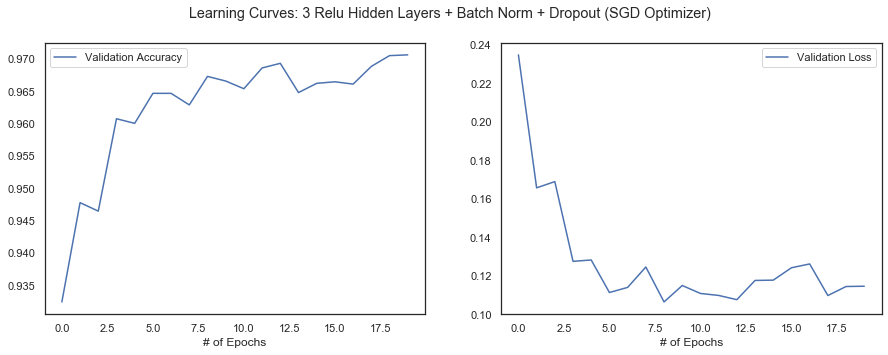

In [46]:
batch_size = 128
n_epochs = 20
learning_rate = 0.1
verbose = 0 # set this = 1 to see training progress
optimizer = SGD(lr=learning_rate)

model = NeuralNetwork("3 Relu Hidden Layers + Batch Norm + Dropout (SGD Optimizer)", batch_size, n_epochs, optimizer, verbose)
model.add_(Dense(64, activation="relu", input_shape=(784,)))
model.add_(BatchNormalization())

model.add_(Dense(64, activation="relu"))
model.add_(BatchNormalization())

model.add_(Dense(64, activation="relu"))
model.add_(BatchNormalization())
model.add_(Dropout(0.2))

model.add_(Dense(10, activation="softmax"))

model.summary_()
model.compile_and_fit()
model.plot_learning_curves()

In [40]:
results = model.evaluate_()
results

8400/8400 [==============================] - 1s 64us/step


[0.11772265955096199, 0.9672619104385376]

In [44]:
predictions = model.predict_(test)
predictions[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3], dtype=int64)

We can preview individual digits in the test set and observe whether any of the model predictions are correct.

In [ ]:
preview_index = 4 # The index of the digit in the training set to preview

fig, ax = plt.subplots(figsize=(5,5))
image = test.iloc[preview_index].values.reshape((28,28))
plt.imshow(image, cmap="Greys")
plt.axis("off")

plt.suptitle("Previewing Digit #{}".format(preview_index + 1), y=0.9)
plt.show()

### Compare Varying Amounts of Dropout

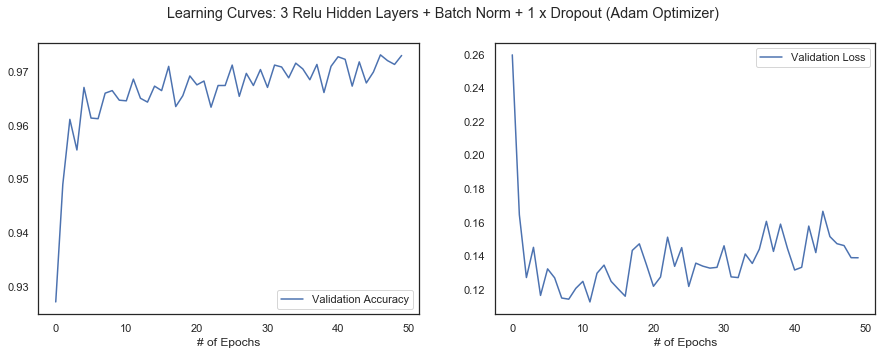

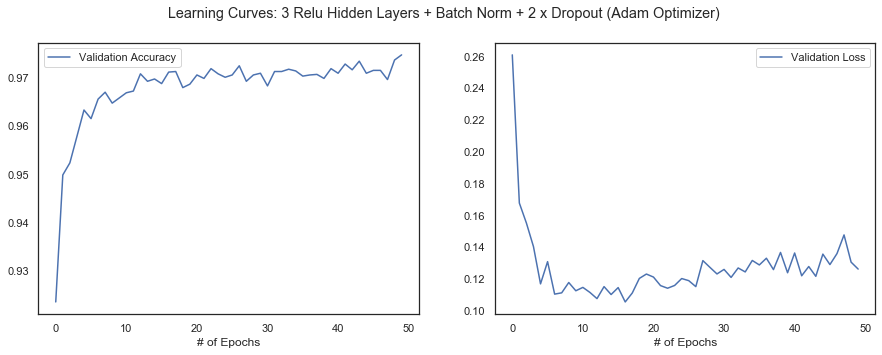

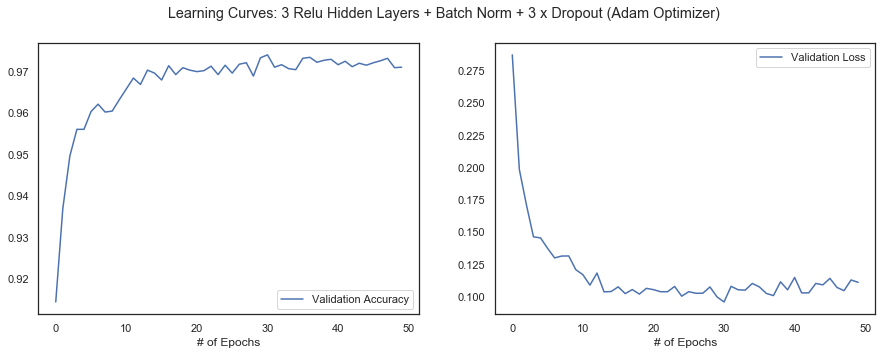

In [28]:
batch_size = 128
n_epochs = 50
verbose = 0
optimizer = "adam"

# 1 round of dropout
model_1d = NeuralNetwork("3 Relu Hidden Layers + Batch Norm + 1 x Dropout (Adam Optimizer)", batch_size, n_epochs, optimizer, verbose)
model_1d.add_(Dense(64, activation="relu", input_shape=(784,)))
model_1d.add_(BatchNormalization())

model_1d.add_(Dense(64, activation="relu"))
model_1d.add_(BatchNormalization())

model_1d.add_(Dense(64, activation="relu"))
model_1d.add_(BatchNormalization())
model_1d.add_(Dropout(0.2))

model_1d.add_(Dense(10, activation="softmax"))

model_1d.compile_and_fit()
model_1d.plot_learning_curves()

# 2 rounds of dropout
model_2d = NeuralNetwork("3 Relu Hidden Layers + Batch Norm + 2 x Dropout (Adam Optimizer)", batch_size, n_epochs, optimizer, verbose)
model_2d.add_(Dense(64, activation="relu", input_shape=(784,)))
model_2d.add_(BatchNormalization())

model_2d.add_(Dense(64, activation="relu"))
model_2d.add_(BatchNormalization())
model_2d.add_(Dropout(0.2))

model_2d.add_(Dense(64, activation="relu"))
model_2d.add_(BatchNormalization())
model_2d.add_(Dropout(0.2))

model_2d.add_(Dense(10, activation="softmax"))

model_2d.compile_and_fit()
model_2d.plot_learning_curves()

# 3 rounds of dropout
model_3d = NeuralNetwork("3 Relu Hidden Layers + Batch Norm + 3 x Dropout (Adam Optimizer)", batch_size, n_epochs, optimizer, verbose)
model_3d.add_(Dense(64, activation="relu", input_shape=(784,)))
model_3d.add_(BatchNormalization())
model_3d.add_(Dropout(0.2))

model_3d.add_(Dense(64, activation="relu"))
model_3d.add_(BatchNormalization())
model_3d.add_(Dropout(0.2))

model_3d.add_(Dense(64, activation="relu"))
model_3d.add_(BatchNormalization())
model_3d.add_(Dropout(0.2))

model_3d.add_(Dense(10, activation="softmax"))

model_3d.compile_and_fit()
model_3d.plot_learning_curves()

In [30]:
model_1d.evaluate_()

8400/8400 [==============================] - 1s 62us/step


[0.1385533304370585, 0.9729762077331543]

In [31]:
model_2d.evaluate_()

8400/8400 [==============================] - 0s 55us/step


[0.12585204632509323, 0.9746428728103638]

In [32]:
model_3d.evaluate_()

8400/8400 [==============================] - 1s 72us/step


[0.11078500510681243, 0.9709523916244507]

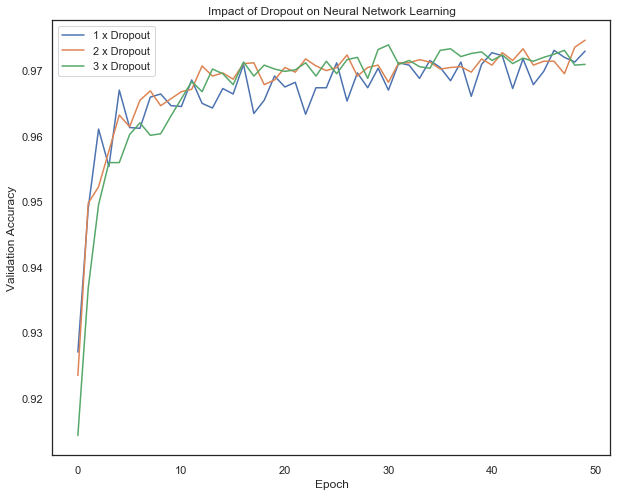

In [34]:
plt.plot(model_1d.history.history["val_accuracy"], label="1 x Dropout")
plt.plot(model_2d.history.history["val_accuracy"], label="2 x Dropout")
plt.plot(model_3d.history.history["val_accuracy"], label="3 x Dropout")
plt.legend()
plt.title("Impact of Dropout on Neural Network Learning")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.show()

### Convolutional Neural Networks (CNN)

In [73]:
X_train_2D = X_train.values.reshape(-1,28,28,1) # Keras requires an extra dimension representing the image channel
X_valid_2D = X_valid.values.reshape(-1,28,28,1)
train = train.values.reshape(-1,28,28,1)
test_2D = test.values.reshape(-1,28,28,1)

In [52]:
batch_size = 128
n_epochs = 10
verbose = 1
optimizer = "adam"

# cnn = NeuralNetwork("CNN", batch_size, n_epochs, optimizer, verbose)
cnn = Sequential()

# 1st convolutional layer
cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))

# 2nd convolutional layer
cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))

# reduce computational complexity
cnn.add(MaxPooling2D(pool_size=(2,2)))

# dropout
cnn.add(Dropout(0.25))

# dimensionality reduction
cnn.add(Flatten())

# dense layer
cnn.add(Dense(128, activation="relu"))
        
# dropout
cnn.add(Dropout(0.5))

# output
cnn.add(Dense(10, activation="softmax"))

cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

In [53]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn.fit(x=X_train_2D,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=1,
                      validation_data=(X_valid_2D, y_valid))

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 27s 816us/step - loss: 0.3229 - accuracy: 0.9015 - val_loss: 0.0806 - val_accuracy: 0.9762
Epoch 2/10
33600/33600 [==============================] - 27s 815us/step - loss: 0.1059 - accuracy: 0.9685 - val_loss: 0.0550 - val_accuracy: 0.9843
Epoch 3/10
33600/33600 [==============================] - 27s 813us/step - loss: 0.0810 - accuracy: 0.9753 - val_loss: 0.0445 - val_accuracy: 0.9865
Epoch 4/10
33600/33600 [==============================] - 27s 795us/step - loss: 0.0600 - accuracy: 0.9817 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 5/10
33600/33600 [==============================] - 27s 815us/step - loss: 0.0513 - accuracy: 0.9839 - val_loss: 0.0399 - val_accuracy: 0.9876
Epoch 6/10
33600/33600 [==============================] - 28s 831us/step - loss: 0.0460 - accuracy: 0.9854 - val_loss: 0.0396 - val_accuracy: 0.9875
Epoch 7/10
33600/33600 [==============================] -

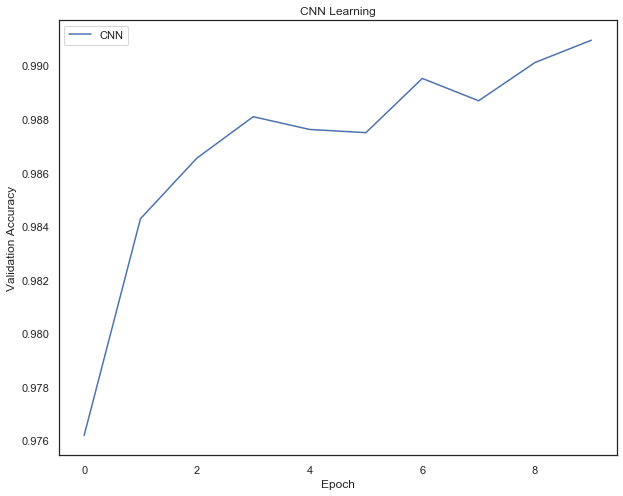

In [54]:
plt.plot(cnn_history.history["val_accuracy"], label="CNN")
plt.legend()
plt.title("CNN Learning")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.show()

### CNNs: Adding More Conv Blocks

In [62]:
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

batch_size = 128
n_epochs = 10
verbose = 1
optimizer = "adam"

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(256, activation="relu"))
cnn.add(Dropout(0.5))

cnn.add(Dense(10, activation="softmax"))

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn.fit(x=X_train_2D,
                      y=y_train,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=1,
                      validation_data=(X_valid_2D, y_valid))

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 24s 714us/step - loss: 0.3644 - accuracy: 0.8832 - val_loss: 0.0874 - val_accuracy: 0.9742
Epoch 2/10
33600/33600 [==============================] - 24s 711us/step - loss: 0.0989 - accuracy: 0.9690 - val_loss: 0.0593 - val_accuracy: 0.9831
Epoch 3/10
33600/33600 [==============================] - 24s 701us/step - loss: 0.0739 - accuracy: 0.9777 - val_loss: 0.0368 - val_accuracy: 0.9862
Epoch 4/10
33600/33600 [==============================] - 23s 696us/step - loss: 0.0565 - accuracy: 0.9824 - val_loss: 0.0427 - val_accuracy: 0.9855
Epoch 5/10
33600/33600 [==============================] - 24s 715us/step - loss: 0.0485 - accuracy: 0.9846 - val_loss: 0.0323 - val_accuracy: 0.9880
Epoch 6/10
33600/33600 [==============================] - 24s 727us/step - loss: 0.0417 - accuracy: 0.9875 - val_loss: 0.0284 - val_accuracy: 0.9905
Epoch 7/10
33600/33600 [==============================] -

### Training on All Training Data

In [76]:
batch_size = 128
n_epochs = 10
verbose = 1
optimizer = "adam"

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
cnn.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(256, activation="relu"))
cnn.add(Dropout(0.5))

cnn.add(Dense(10, activation="softmax"))

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn.fit(x=train,
                      y=y,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=1)

Epoch 1/10
42000/42000 [==============================] - 28s 671us/step - loss: 0.3362 - accuracy: 0.8904s - loss: 0.3363 - accuracy: 0.89
Epoch 2/10
42000/42000 [==============================] - 28s 668us/step - loss: 0.0920 - accuracy: 0.9716
Epoch 3/10
42000/42000 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.98 - 28s 675us/step - loss: 0.0643 - accuracy: 0.9803
Epoch 4/10
42000/42000 [==============================] - 28s 664us/step - loss: 0.0513 - accuracy: 0.9845
Epoch 5/10
42000/42000 [==============================] - 27s 654us/step - loss: 0.0459 - accuracy: 0.9860
Epoch 6/10
42000/42000 [==============================] - 28s 658us/step - loss: 0.0376 - accuracy: 0.9885
Epoch 7/10
42000/42000 [==============================] - 28s 672us/step - loss: 0.0347 - accuracy: 0.9890
Epoch 8/10
42000/42000 [==============================] - 29s 690us/step - loss: 0.0310 - accuracy: 0.9901
Epoch 9/10
42000/42000 [==============================] - 27s 632us/s

In [78]:
batch_size = 128
n_epochs = 10
verbose = 1
optimizer = "adam"

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(5,5), activation="relu", padding="Same", input_shape=(28,28,1)))
cnn.add(Conv2D(32, kernel_size=(5,5), activation="relu", padding="Same"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="Same"))
cnn.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding="Same"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(256, activation="relu"))
cnn.add(Dropout(0.5))

cnn.add(Dense(10, activation="softmax"))

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_history = cnn.fit(x=train,
                      y=y,
                      batch_size=batch_size,
                      epochs=n_epochs,
                      verbose=1)

Epoch 1/10
42000/42000 [==============================] - 75s 2ms/step - loss: 0.2643 - accuracy: 0.9150
Epoch 2/10
42000/42000 [==============================] - 74s 2ms/step - loss: 0.0830 - accuracy: 0.9751
Epoch 3/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.0563 - accuracy: 0.9823
Epoch 4/10
42000/42000 [==============================] - 74s 2ms/step - loss: 0.0498 - accuracy: 0.9848
Epoch 5/10
42000/42000 [==============================] - 72s 2ms/step - loss: 0.0395 - accuracy: 0.9880
Epoch 6/10
42000/42000 [==============================] - 72s 2ms/step - loss: 0.0354 - accuracy: 0.9896
Epoch 7/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.0317 - accuracy: 0.9904
Epoch 8/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.0300 - accuracy: 0.9904
Epoch 9/10
42000/42000 [==============================] - 73s 2ms/step - loss: 0.0265 - accuracy: 0.9917
Epoch 10/10
42000/42000 [==============================

In [79]:
output = generate_output(cnn, test_2D, "cnn_2_levels_5x5_all_training_data", save=True)
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
